In [1]:
import pandas as pd

import os

import numpy as np

import sys
sys.path.append("../..")

import matplotlib.pyplot as plt
import seaborn as sns
from digitalhistopathology.embeddings.gene_embedding import GeneEmbedding

import warnings
warnings.filterwarnings("ignore")

import anndata as ad
import glob
import scanpy as sc

import gzip
import pickle

import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

from PIL import Image
from matplotlib.patches import Rectangle

from digitalhistopathology.datasets.real_datasets import TNBCDataset


/storage/homefs/lf25x455/.conda/envs/digitalhisto/lib/python3.10/site-packages/stlearn/tl/cci/het.py:206: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)
2025-11-27 16:22:04.118668: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :
2025-11-27 16:22:04.118773: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such

[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [2]:
import json

# Load configuration
with open("../../config/config_notebooks_TNBC.json", "r") as config_file:
    config = json.load(config_file)

In [3]:
with gzip.open(config['patches_info_path']) as f:
    patches_info = pickle.load(f)

In [4]:
# UNI full koleo
labels = pd.read_csv("../../results/TNBC/benchmark//uni_full_models/invasive_cancer_clustering/kmeans/uni_full_koleo_4096_prototypes/invasive_labels_6_clusters_umap_min_dist_0.001_n_neighbors_100.csv", index_col=0)


In [5]:
patches_info = pd.DataFrame(patches_info)

In [6]:
patches_info.columns

Index(['path', 'name', 'mpp_height', 'mpp_width', 'shape_micron',
       'shape_pixel', 'overlap_pixel', 'path_origin', 'name_origin',
       'shape_origin', 'start_height_origin', 'start_width_origin',
       'extension_origin', 'batch', 'tumor', 'mean_intensity',
       'median_intensity', 'std_intensity', 'entropy_intensity', 'spots_info'],
      dtype='object')

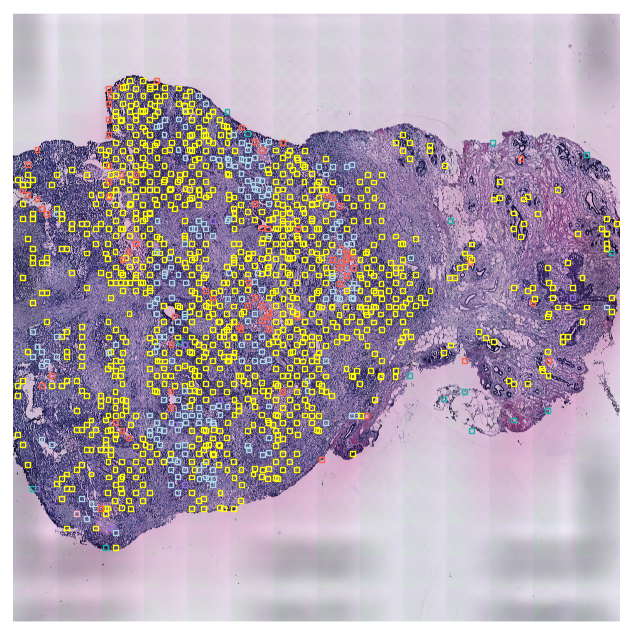

In [12]:
palette={'0': 'lightseagreen', '1': 'lightblue', '2': 'lightpink', '3': 'yellow', '4': 'mediumpurple', '5': 'tomato', 'not invasive': 'white'}

for patient in ["TNBC91"]:

    patient_emb = patches_info[patches_info["name_origin"].str.contains(f"{patient}_")]

    for img_path in patient_emb["path_origin"].unique():

        img_emb = patches_info[patches_info["path_origin"] == img_path]
        image = Image.open(img_path)
        image = np.array(image)
        img_emb['predicted_label'] = [str(labels.loc[idx, 'predicted_label']) if idx in labels.index else "not invasive" for idx in img_emb["name"].values]

        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(image)
        
        for x, y, px_size, label in zip(img_emb['start_width_origin'], 
                                img_emb['start_height_origin'],
                                img_emb['shape_pixel'], 
                                img_emb['predicted_label']):
            if label != "not invasive":
                color = palette[label]
                rect = Rectangle((x, y), px_size, px_size, linewidth=1, edgecolor=color, facecolor='none')
                ax.add_patch(rect)
        ax.set_axis_off()

    plt.savefig(os.path.join(config["figures_folder"], "Figure4", f"slide_uni_full_koleo_4096_{patient}_predicted_labels.pdf"), bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

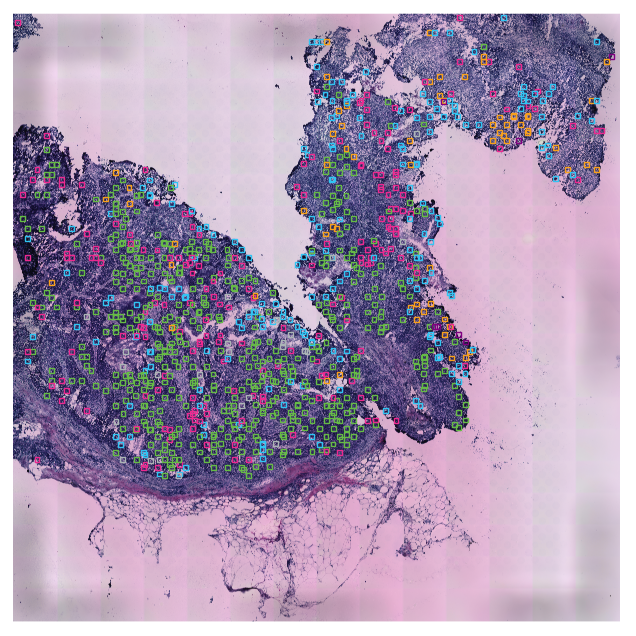

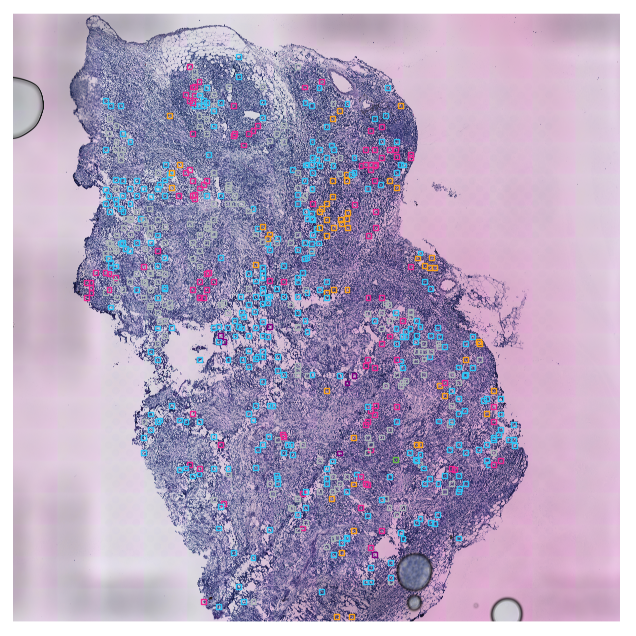

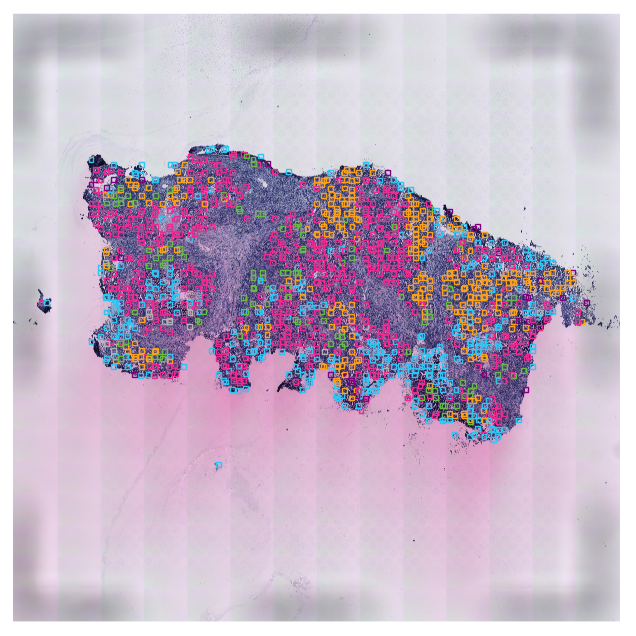

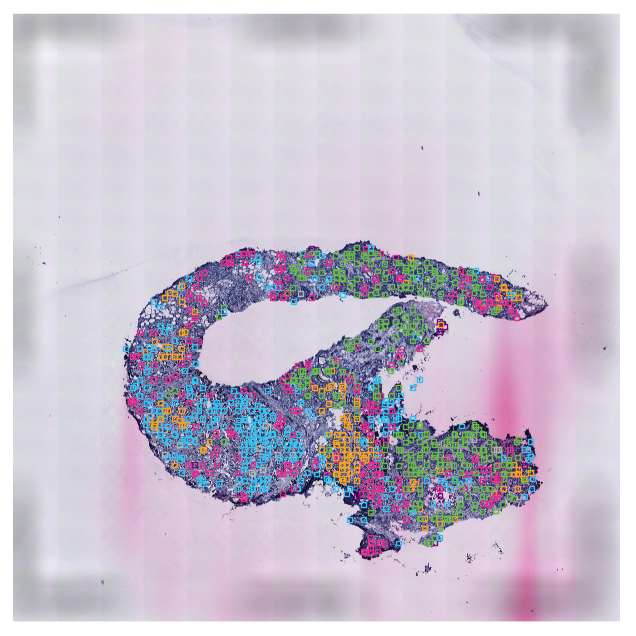

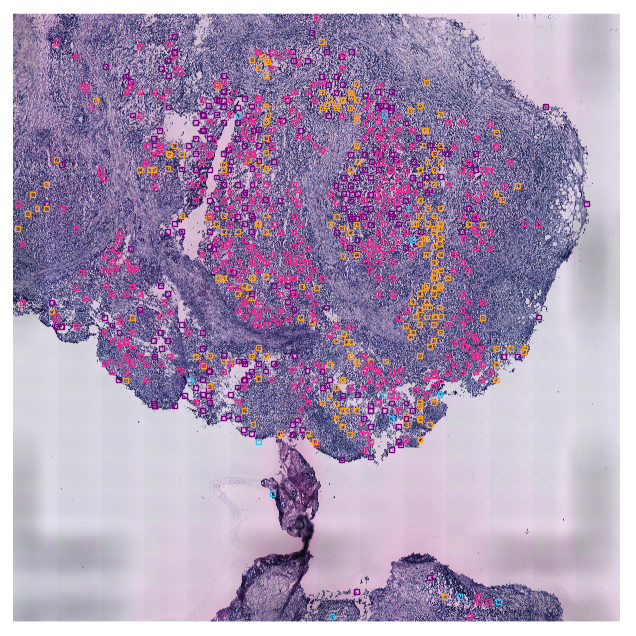

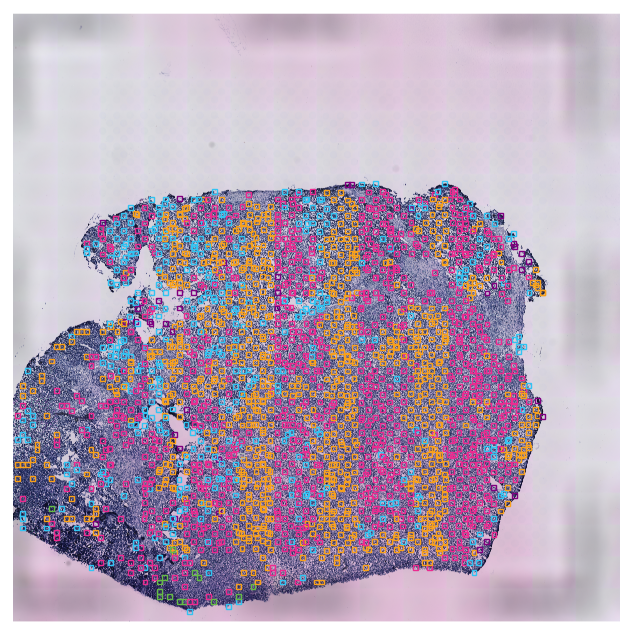

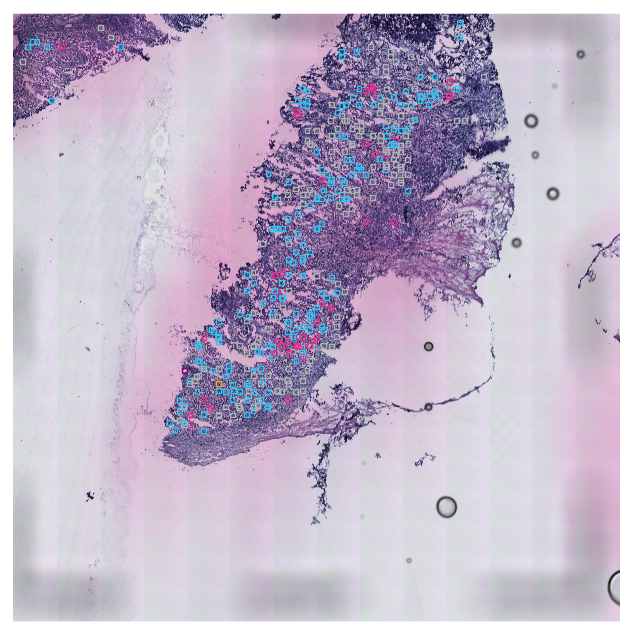

In [7]:
for patient in ["TNB14", "TNBC88", "TNBC20", "TNBC92", "TNBC78", "TNBC69", "TNBC25", "TNBC6"]:

    patient_emb = patches_info[patches_info["name_origin"].str.contains(f"{patient}_")]

    for img_path in patient_emb["path_origin"].unique():

        img_emb = patches_info[patches_info["path_origin"] == img_path]
        image = Image.open(img_path)
        image = np.array(image)
        img_emb['predicted_label'] = [str(labels.loc[idx, 'predicted_label']) if idx in labels.index else "not invasive" for idx in img_emb["name"].values]

        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(image)
        
        for x, y, px_size, label in zip(img_emb['start_width_origin'], 
                                img_emb['start_height_origin'],
                                img_emb['shape_pixel'], 
                                img_emb['predicted_label']):
            if label != "not invasive":
                color = palette[label]
                rect = Rectangle((x, y), px_size, px_size, linewidth=1, edgecolor=color, facecolor='none')
                ax.add_patch(rect)
        ax.set_axis_off()

    plt.savefig(os.path.join(config["figures_folder"], "Figure4", f"slide_uni_full_koleo_4096_{patient}_predicted_labels.pdf"), bbox_inches='tight')


In [ ]:

for patient in ["TNBC5", "TNBC6", "TNBC9", "TNBC14", "TNBC25", "TNBC20", "TNBC88"]:
    print(patient)
    subset_emb = GeneEmbedding()
    n_patches = len(patches_info[patches_info["name_origin"] == patient])
    subset_emb.emb = ad.AnnData(X=np.zeros((n_patches, 1)))
    subset_emb.emb.obs = patches_info[patches_info["name_origin"] == patient]
    # subset_emb.emb = emb_raw_gene[emb_raw_gene.obs["name_origin"] == patient]
    # subset_emb.emb.obs = subset_emb.emb.obs.drop(['tumor', 'name_origin'], axis=1).merge(pd.DataFrame(patches_info), left_index=True, right_on='name')
    subset_emb.emb.obs.set_index('name', inplace=True)
    subset_emb.emb.obs['predicted_label'] = [str(labels.loc[idx, 'predicted_label']) if idx in labels.index else "not invasive" for idx in subset_emb.emb.obs.index]
    
    subset_emb.emb = subset_emb.emb[subset_emb.emb.obs["predicted_label"] != "not invasive"]

    subset_emb.plot_spot_location_with_color_on_origin_image(color='predicted_label', s=10, palette=palette)

    plt.savefig(f"../Figures/Fig4/slide_uni_full_koleo_16384_{patient}_predicted_labels.pdf", bbox_inches='tight')


In [ ]:
emb_raw_gene = ad.read_h5ad("../results/molecular/filtered_gene_expression.h5ad")

with gzip.open(config['patches_info_path']) as f:
    patches_info = pickle.load(f)
    
    
def create_legend_gene_expression(gene_exp):
    if gene_exp == 0:
        return "Not expressed"
    elif gene_exp < 2:
        return "Low expression"
    elif gene_exp < 4:
        return "Medium expression"
    else:
        return "High expression"


In [ ]:
patches_info = pd.DataFrame(patches_info)


In [ ]:
palette = {'0': '#66BB46', 
           '1': "#AD66FF", 
           '2': "#F9A11B", 
           '3': '#31C4F3', 
           '4': '#ACB5B6',
           '5': "#965D59",
           '6': '#EC2A90',
           '7': '#2F2F8E',
           '8': "#FFE340"}